In [19]:
# Simulate the data

import numpy as np

n, p = 500, 100
sigma = 0.5  # noise std
np.random.seed(42)

X = np.random.randn(n, p)
beta_star = np.random.randn(p)
epsilon = sigma * np.random.randn(n)
y = X @ beta_star + epsilon


In [60]:
# SGD Implementation 
def run_sgd(X, y, beta_init, lr=0.002, batch_size=64, epochs=2000):
    n, p = X.shape
    beta = beta_init.copy()
    beta_hist = []

    for _ in range(epochs):
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X[idx], y[idx]
        grad = X_batch.T @ (y_batch - X_batch @ beta) / batch_size
        beta += lr * grad
        beta_hist.append(beta.copy())

    return np.array(beta_hist)


In [ ]:
def run_sgf_em(X, y, beta_init, epsilon=0.002, m=64, steps=2000):
    n, p = X.shape
    beta = beta_init.copy()
    beta_hist = []

    for _ in range(steps):
        # Full gradient (drift)
        full_grad = X.T @ (y - X @ beta) / n

        # Sample mini-batch
        batch_idx = np.random.choice(n, m, replace=False)
        X_batch = X[batch_idx]
        y_batch = y[batch_idx]

        # Compute gradients for each sample in batch
        grads = np.array([
            X_batch[i] * (y_batch[i] - X_batch[i] @ beta)
            for i in range(m)
        ])

        # Covariance of gradients
        Σ_hat = np.cov(grads.T)  # shape (p, p)
        Σ_hat += 1e-6 * np.eye(p)  # numerical stability

        # Square root via Cholesky
        try:
            Σ_sqrt = np.linalg.cholesky(Σ_hat)
        except np.linalg.LinAlgError:
            Σ_sqrt = np.linalg.svd(Σ_hat)[0]  # fallback

        # Sample z_k
        z_k = np.random.randn(p)

        # Update
        beta += epsilon * full_grad + epsilon * (Σ_sqrt @ z_k)
        beta_hist.append(beta.copy())

    return np.array(beta_hist)



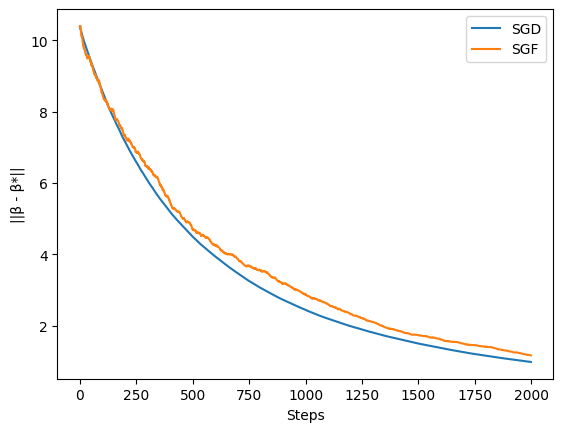

In [62]:
import matplotlib.pyplot as plt
from numpy.linalg import norm

beta_0 = np.zeros(p)
sgd_path = run_sgd(X, y, beta_0)
sgf_path = run_sgf_em(X, y, beta_0)

plt.plot([norm(b - beta_star) for b in sgd_path], label='SGD')
plt.plot([norm(b - beta_star) for b in sgf_path], label='SGF')
plt.ylabel('||β - β*||')
plt.xlabel('Steps')
plt.legend()
plt.show()
